# Review Text Attributes Models

## Import libraries and files

This notebook builds a range of machine learning models based upon the text characteristics within the review itself.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing and feature engineering
* Section 3 - Base models


Features:



# Import libaries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import string
import re
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFECV,VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, balanced_accuracy_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,fbeta_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in balanced datasets from Post Attributes Base notebook
train = pd.read_csv("combined_train.csv",index_col = 0)
val = pd.read_csv("combined_val.csv",index_col = 0)
test = pd.read_csv("combined_test.csv",index_col = 0)

In [3]:
train.head(2)

,Name,Category,Town,Type,Contributions,Title,Review,Date,LocCode,Cuisine,Score
245,Trevali Buest House,Accommodation,Bognor,B&B/Inn,315,Central B & B,"We had room 6, excellent view, we could see th...",1.0,2.0,0,0
209,Sea View,Accommodation,Littlehampton,Hotel,50,Not what it used to be...,"We lived in the area for 25 years and in fact,...",2.0,2.0,0,1


# Section 1: Data Pre-processing and Feature Engineering

### Process data as per Exploratory Data Analysis 2

In [4]:
# Function to find emojis in text
def find_emojies(text):
    EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
  )
    emoji = re.findall(EMOJI_PATTERN, text)
    return emoji

In [5]:
def process_data(df):   

    df["all_text"] = df["Title"] + ' ' + df["Review"]
    df["num_words"] = df['all_text'].str.split().apply(len)
    df["num_chars"] = df['all_text'].apply(lambda x: len(x) - x.count(" "))
    df['uppercase'] = df["all_text"].apply(lambda x: sum(char.isupper() for char in x))
    df["prop_uc"] = df["uppercase"]/df["num_chars"]
    df['special_chars'] = df["all_text"].apply(lambda x: sum(char in string.punctuation for char in x))
    df["prop_sc"] = df["special_chars"]/df["num_chars"]
    df["Emoji"] = df["all_text"].apply(find_emojies)
    df["Emoji"]= df["Emoji"].apply(lambda x: np.nan if len(x)==0 else x)
    df["Emoji"] = df["Emoji"].fillna(0)
    df["Emoji_count"] = df["Emoji"].apply(lambda x:len(x) if isinstance(x,list) else 0)
    df["Emoji_prop"] = df["Emoji_count"]/df["num_words"]
    df = df.drop(columns = ['Name', 'Category', 'Town', 'Type', 'Contributions', 'Title', 'Review','all_text','Date', 
                       'LocCode', 'Cuisine','num_chars','uppercase','special_chars','Emoji','Emoji_count'], axis = 1)
    return df

In [6]:
train_df = process_data(train)
val_df = process_data(val)

In [7]:
train_df.head()

,Score,num_words,prop_uc,prop_sc,Emoji_prop
245,0,132,0.036842,0.038596,0.0
209,1,272,0.020572,0.047406,0.0
28,0,93,0.040609,0.030457,0.0
365,0,173,0.023499,0.026110,0.0
389,1,84,0.028424,0.020672,0.0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1453 entries, 245 to 66
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Score       1453 non-null   int64  
 1   num_words   1453 non-null   int64  
 2   prop_uc     1453 non-null   float64
 3   prop_sc     1453 non-null   float64
 4   Emoji_prop  1453 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 68.1 KB


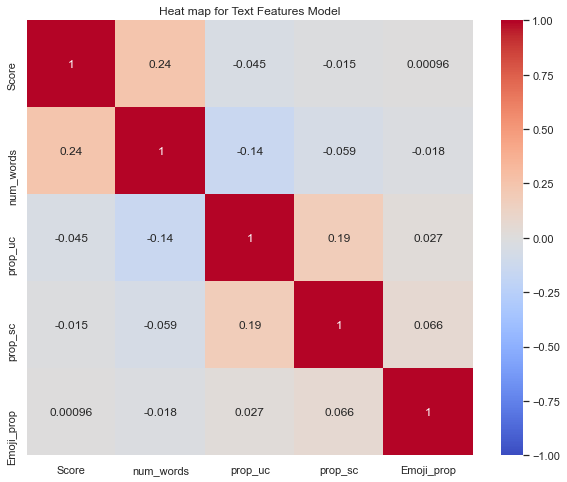

In [9]:
# Heatmap to show relationships
cor_mat = train_df.corr()
plt.figure(figsize=(10,8))
plt.title("Heat map for Text Features Model")
#plot heat map
g=sns.heatmap(cor_mat,annot=True,vmin=-1, cmap='coolwarm')

In [10]:
# Define X and y variables
X_train = train_df.drop(["Score"], axis = 1)
y_train = train_df["Score"]
X_val = val_df.drop(["Score"], axis = 1)
y_val = val_df["Score"]

In [11]:
# Check statistics to see if means and standard deviations vary so scaling is appropriate
X_train.describe()

,num_words,prop_uc,prop_sc,Emoji_prop
count,1453.000000,1453.000000,1453.000000,1453.000000
mean,110.372333,0.028423,0.027801,0.000167
std,106.964740,0.018194,0.012650,0.002443
min,17.000000,0.000000,0.000000,0.000000
25%,49.000000,0.019324,0.019672,0.000000
50%,78.000000,0.025267,0.026316,0.000000
75%,138.000000,0.033333,0.033981,0.000000
max,1648.000000,0.404396,0.129450,0.066667


In [12]:
# Scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)


In [13]:
X_train = pd.DataFrame(X_train_scaled)
X_train.columns = ["Word_len","Prop_uc","Prop_sc","Prop_emojis"]
X_train.head()

,Word_len,Prop_uc,Prop_sc,Prop_emojis
0,0.070509,0.091104,0.298158,0.0
1,0.156346,0.050872,0.366212,0.0
2,0.046597,0.100419,0.235279,0.0
3,0.095647,0.058108,0.201697,0.0
4,0.041079,0.070287,0.159690,0.0


In [14]:
X_val = pd.DataFrame(X_val_scaled)
X_val.columns = ["Word_len","Prop_uc","Prop_sc","Prop_emojis"]

# Section 2: Feature Selection

In [15]:
# Recursive Feature Elimination using cross validation
def recurse(m,X,y):
    rfecv = RFECV(estimator = m, step = 1, scoring = "accuracy")
    rfecv.fit(X,y)
    rfecv.transform(X)
    return rfecv

In [16]:
result_lr = recurse(LogisticRegression(),X_train,y_train)
print(result_lr.n_features_)

1


In [17]:
print(result_lr.support_)
print(result_lr.grid_scores_)
print(result_lr.ranking_)

[ True False False False]
[0.6235644  0.62013035 0.62013035 0.62081763]
[1 2 4 3]


In [18]:
X_train.columns

Index(['Word_len', 'Prop_uc', 'Prop_sc', 'Prop_emojis'], dtype='object')

In [19]:
X_train = X_train.drop(columns = ["Prop_emojis"], axis = 1)
X_val = X_val.drop(columns = ["Prop_emojis"],axis = 1)

# Section 3: Training Models

In [20]:
# Function to train with specified model on the training set
def train_accuracy(model):
    kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    scores = cross_val_score(model, X_train,y_train ,cv = kf, scoring = "accuracy", n_jobs =-1)
    return scores.mean()

In [37]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(1453, 3) (183, 3) (1453,) (183,)


### a) Dummy Classifer and Baseline ML Models

In [38]:
# Set models with defaut parameters
dummy_model = DummyClassifier(strategy = 'uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True, kernel = 'rbf')

In [39]:
# Train models
dum_train = train_accuracy(dummy_model)
nb_train = train_accuracy(nb)
log_train = train_accuracy(lr)
rf_train = train_accuracy(rf)
svm_train = train_accuracy(svm)

In [40]:
train_summary = pd.DataFrame({"Dummy":[dum_train],"Naive Bayes":[nb_train],"LogReg":[log_train],"Random Forest": [rf_train],
                              "SVM":[svm_train]})
train_summary

,Dummy,Naive Bayes,LogReg,Random Forest,SVM
0,0.48659,0.612302,0.623988,0.61114,0.6318


### Predicting with each Model

In [26]:
# Create function to run diagnostic reports and graphs

def run_mod(model,X,y):
    
    # Fit model on training set and predict on test set
    model_name = str(model)
    model.fit(X,y)
    y_pred = model.predict(X_val)
        
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, val_scores = learning_curve(model,X,y, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    val_mean = np.mean(val_scores, axis = 1)
    val_std = np.mean(val_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, val_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Balanced_acc":balanced_accuracy,
                                    "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
     
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    

              precision    recall  f1-score   support

           0       0.57      0.84      0.68        91
           1       0.70      0.38      0.49        92

    accuracy                           0.61       183
   macro avg       0.64      0.61      0.59       183
weighted avg       0.64      0.61      0.59       183



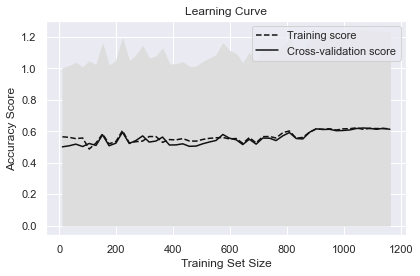

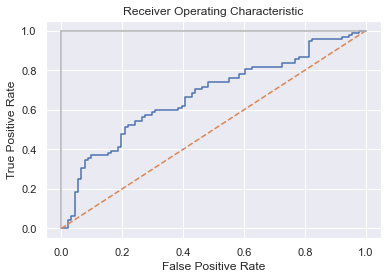

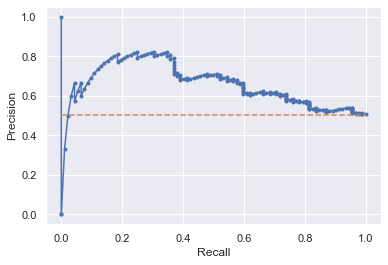

Best F1 score: 0.4929577464788733 Best threshold value: 0.1


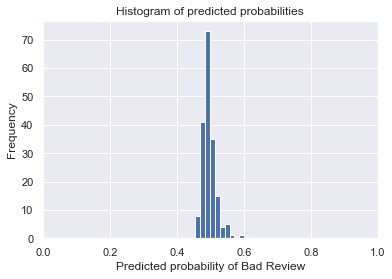

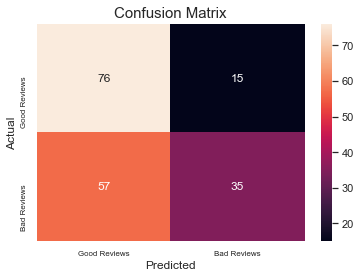

In [27]:
run_mod(nb,X_train,y_train)

In [28]:
nb_base = run_mod.results
nb_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.606557,0.6078,0.7,0.380435,0.492958,0.41866,0.672121,0.653674


              precision    recall  f1-score   support

           0       0.63      0.67      0.65        91
           1       0.65      0.61      0.63        92

    accuracy                           0.64       183
   macro avg       0.64      0.64      0.64       183
weighted avg       0.64      0.64      0.64       183



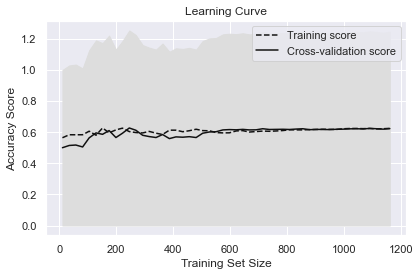

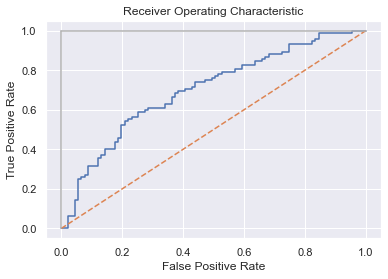

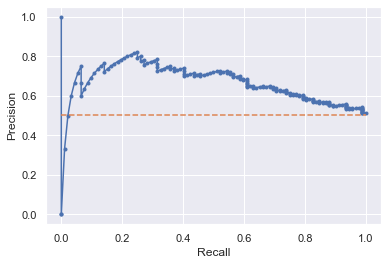

Best F1 score: 0.6292134831460675 Best threshold value: 0.1


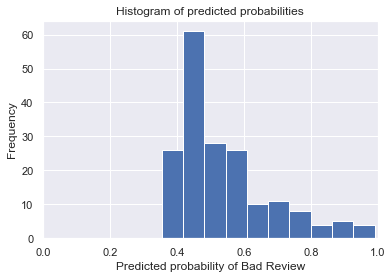

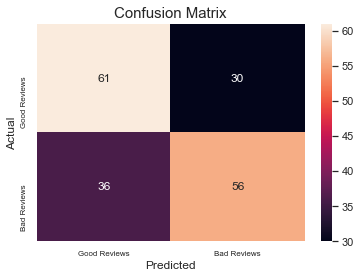

In [29]:
run_mod(lr,X_train,y_train)

In [30]:
lr_base = run_mod.results
lr_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.639344,0.639513,0.651163,0.608696,0.629213,0.61674,0.700072,0.664083


              precision    recall  f1-score   support

           0       0.62      0.05      0.10        91
           1       0.51      0.97      0.67        92

    accuracy                           0.51       183
   macro avg       0.57      0.51      0.38       183
weighted avg       0.57      0.51      0.39       183



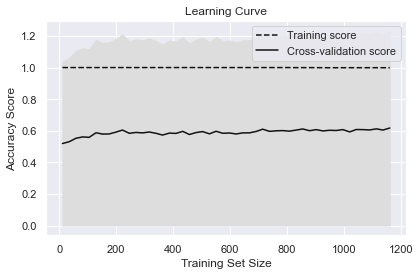

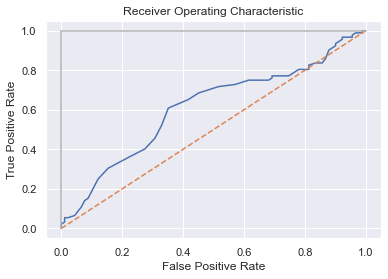

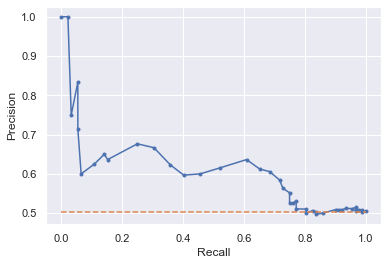

Best F1 score: 0.6666666666666666 Best threshold value: 0.1


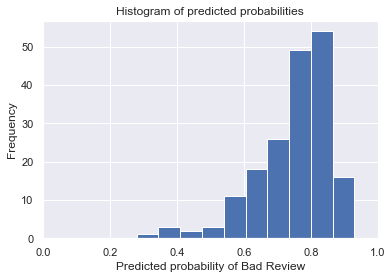

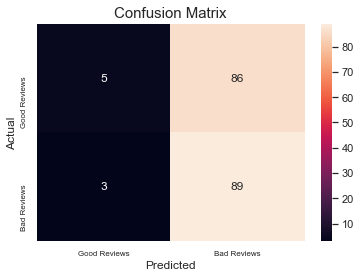

In [31]:
run_mod(rf,X_train,y_train)

In [32]:
rf_base = run_mod.results
rf_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.513661,0.511168,0.508571,0.967391,0.666667,0.819521,0.609591,0.610755


              precision    recall  f1-score   support

           0       0.50      0.01      0.02        91
           1       0.50      0.99      0.67        92

    accuracy                           0.50       183
   macro avg       0.50      0.50      0.34       183
weighted avg       0.50      0.50      0.35       183



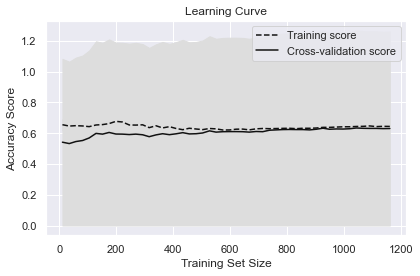

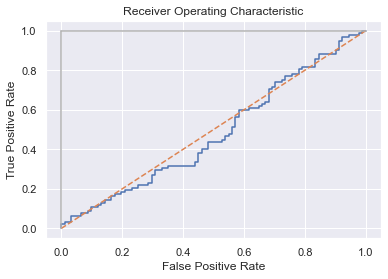

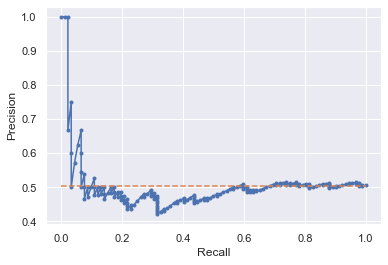

Best F1 score: 0.6666666666666667 Best threshold value: 0.1


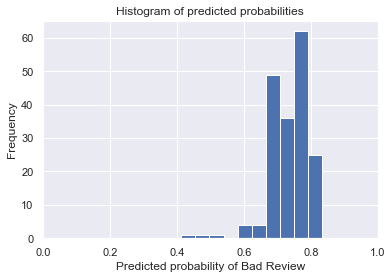

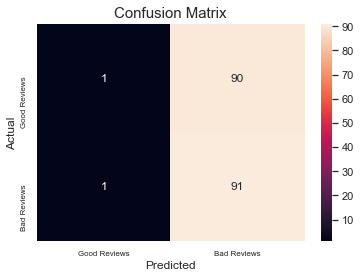

In [33]:
run_mod(svm,X_train,y_train)

In [34]:
svm_base = run_mod.results
svm_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.502732,0.50006,0.502762,0.98913,0.666667,0.82878,0.479933,0.50342


In [35]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector"]

training_summary = pd.concat([nb_base,lr_base,rf_base,svm_base])
training_summary.set_index([models],inplace = True)
training_summary

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.606557,0.607800,0.700000,0.380435,0.492958,0.418660,0.672121,0.653674
Logistic Regression,0.639344,0.639513,0.651163,0.608696,0.629213,0.616740,0.700072,0.664083
Random Forest,0.513661,0.511168,0.508571,0.967391,0.666667,0.819521,0.609591,0.610755
Support Vector,0.502732,0.500060,0.502762,0.989130,0.666667,0.828780,0.479933,0.503420
